**Requirements:**
* Trained models
* RDKit: 
     * fine-tuned:      `'c824e42f7ce751cf9a8ed26f0d9e0af7'` 
     * non-pretrained: `'59bdaefb1c1adfaf2976e3fdf62afa21'`

Here everything is in setting 1 (identical gene sets) 

**Outputs:**
* **Figure 2 for RDKit** 
* Figure 5 with DEGs for RDKit
* Supplement Figures 10 & 11 for RDKit
___
# Imports

In [1]:
import os

os.chdir("../..")

In [2]:
import chemCPA 

chemCPA.__file__

'/nfs/staff-ssd/hetzell/code/chemCPA/chemCPA/__init__.py'

In [3]:
import matplotlib
import umap.plot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from utils import load_config, load_dataset, load_smiles, load_model, compute_drug_embeddings, compute_pred, compute_pred_ctrl
from chemCPA.data import load_dataset_splits

from chemCPA.paths import FIGURE_DIR, ROOT

2024-06-26 12:18:57.233281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 12:19:06.511533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-26 12:19:06.512158: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-06-26 12:19:06.512174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
BLACK = False 

if BLACK: 
    plt.style.use('dark_background')
else: 
    matplotlib.style.use("fivethirtyeight")
    matplotlib.style.use("seaborn-talk")
    matplotlib.pyplot.rcParams['savefig.facecolor'] = 'white'
    sns.set_style("whitegrid")

matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams['figure.dpi'] = 300
sns.set_context("poster")

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load model configs and dataset
* Define `seml_collection` and `model_hash` to load data and model

In [6]:
seml_collection = "run_biolord"

# # RDKit
# Only scratch! 
model_hash_pretrained = "469df41600a5cf3b19765574df4178d9" # Fine-tuned
model_hash_scratch = "469df41600a5cf3b19765574df4178d9" # Non-pretrained

## Load config and SMILES

In [7]:
import json 
from tqdm.auto import tqdm
from chemCPA.paths import PROJECT_DIR

# def load_config(seml_collection, model_hash):
#     file_path = PROJECT_DIR / f"{seml_collection}.json"  # Provide path to json

#     with open(file_path) as f:
#         file_data = json.load(f)

#     for _config in tqdm(file_data):
#         if _config["config_hash"] == model_hash:
#             # print(config)
#             config = _config["config"]
#             config["config_hash"] = _config["config_hash"]
#     return config

import seml

In [8]:
config = seml.get_results(db_collection_name=seml_collection, to_data_frame=False, filter_dict={"config_hash": model_hash_pretrained})[0]["config"]
_config = seml.get_results(db_collection_name=seml_collection, to_data_frame=True, filter_dict={"config_hash": model_hash_pretrained})

config["dataset"]["data_params"]["dataset_path"] = ROOT / config["dataset"]["data_params"]["dataset_path"]

dataset, key_dict = load_dataset(config)
config['dataset']['n_vars'] = dataset.n_vars

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
canon_smiles_unique_sorted, smiles_to_pathway_map, smiles_to_drug_map = load_smiles(config, dataset, key_dict, True)

Get list of drugs that are ood in `ood_drugs`

In [10]:
ood_drugs = dataset.obs.drug[dataset.obs[config["dataset"]["data_params"]["split_key"]].isin(['ood'])].unique().to_list()

In [11]:
ood_drugs

['Alvespimycin_(17-DMAG)_HCl',
 'Dacinostat_(LAQ824)',
 'Tanespimycin_(17-AAG)',
 'Belinostat_(PXD101)',
 'TAK-901',
 'Givinostat_(ITF2357)',
 'Quisinostat_(JNJ-26481585)_2HCl',
 'Hesperadin',
 'Flavopiridol_HCl']

## Load dataset splits

In [12]:
config['dataset']['data_params']

{'covariate_keys': 'cell_type',
 'dataset_path': PosixPath('/nfs/staff-ssd/hetzell/code/chemCPA/project_folder/datasets/adata_biolord_split_30.h5ad'),
 'degs_key': 'rank_genes_groups_cov_all',
 'dose_key': 'dose',
 'pert_category': 'condition',
 'perturbation_key': 'drug',
 'smiles_key': 'smiles',
 'split_key': 'split',
 'use_drugs_idx': True}

In [13]:
data_params = config['dataset']['data_params']
datasets = load_dataset_splits(**data_params, return_dataset=False)

___
# Run models 
## Baseline model

In [14]:
dosages = [1e1,1e2,1e3,1e4]
cell_lines = ["A549", "K562", "MCF7"]
use_DEGs = True

In [15]:
drug_r2_baseline_degs, _ = compute_pred_ctrl(dataset=datasets['ood'],
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=True,
                                        verbose=True,
                                       )

drug_r2_baseline_all, _ = compute_pred_ctrl(dataset=datasets['ood'],
                                        dataset_ctrl=datasets['test_control'],
                                        dosages=dosages,
                                        cell_lines=cell_lines,
                                        use_DEGs=False,
                                        verbose=False,
                                       )

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

A549_Alvespimycin_(17-DMAG)_HCl_10.0: 0.91
A549_Belinostat_(PXD101)_100.0: 0.87
A549_Dacinostat_(LAQ824)_10.0: 0.41
A549_Tanespimycin_(17-AAG)_10.0: 0.94
K562_Alvespimycin_(17-DMAG)_HCl_10.0: 0.87
K562_Belinostat_(PXD101)_10.0: 0.75
K562_Belinostat_(PXD101)_100.0: 0.76
K562_Givinostat_(ITF2357)_10.0: 0.79
K562_Tanespimycin_(17-AAG)_10.0: 0.27
MCF7_Alvespimycin_(17-DMAG)_HCl_10.0: 0.94
MCF7_Alvespimycin_(17-DMAG)_HCl_100.0: 0.54
MCF7_Alvespimycin_(17-DMAG)_HCl_1000.0: 0.48
MCF7_Belinostat_(PXD101)_10.0: 0.92
MCF7_Belinostat_(PXD101)_100.0: 0.90
MCF7_Belinostat_(PXD101)_1000.0: 0.73
MCF7_Belinostat_(PXD101)_10000.0: -0.24
MCF7_Dacinostat_(LAQ824)_10.0: 0.72
MCF7_Dacinostat_(LAQ824)_100.0: 0.55
MCF7_Dacinostat_(LAQ824)_1000.0: -0.26
MCF7_Dacinostat_(LAQ824)_10000.0: -0.67
MCF7_Flavopiridol_HCl_10.0: 0.95
MCF7_Givinostat_(ITF2357)_10.0: 0.91
MCF7_Givinostat_(ITF2357)_100.0: 0.90
MCF7_Givinostat_(ITF2357)_1000.0: 0.76
MCF7_Givinostat_(ITF2357)_10000.0: -0.42
MCF7_Hesperadin_10.0: 0.88
MCF7_

0it [00:00, ?it/s]

## Pretrained model

In [16]:
ood_drugs

['Alvespimycin_(17-DMAG)_HCl',
 'Dacinostat_(LAQ824)',
 'Tanespimycin_(17-AAG)',
 'Belinostat_(PXD101)',
 'TAK-901',
 'Givinostat_(ITF2357)',
 'Quisinostat_(JNJ-26481585)_2HCl',
 'Hesperadin',
 'Flavopiridol_HCl']

In [17]:
config["model"]

{'additional_params': {'decoder_activation': 'ReLU',
  'doser_type': 'amortized',
  'patience': 50,
  'seed': 1337},
 'append_ae_layer': True,
 'embedding': {'directory': None, 'model': 'rdkit'},
 'enable_cpa_mode': False,
 'hparams': {'adversary_depth': 3,
  'adversary_lr': 0.0011926173789223548,
  'adversary_steps': 3,
  'adversary_wd': 9.846738873614555e-06,
  'adversary_width': 128,
  'autoencoder_depth': 4,
  'autoencoder_lr': 0.0015751320499779737,
  'autoencoder_wd': 6.251373574521742e-07,
  'autoencoder_width': 256,
  'batch_size': 128,
  'dim': 32,
  'dosers_depth': 3,
  'dosers_lr': 0.0015751320499779737,
  'dosers_wd': 6.251373574521742e-07,
  'dosers_width': 64,
  'dropout': 0.262378,
  'embedding_encoder_depth': 4,
  'embedding_encoder_width': 128,
  'penalty_adversary': 0.4550475813202185,
  'reg_adversary': 9.100951626404369,
  'reg_adversary_cov': 16.165583124257587,
  'reg_multi_task': 0,
  'step_size_lr': 50},
 'load_pretrained': False,
 'pretrained_model_hashes': {'g

In [18]:
# config = load_config(seml_collection, model_hash_pretrained)
config = seml.get_results(db_collection_name=seml_collection, to_data_frame=False, filter_dict={"config_hash": model_hash_pretrained})[0]["config"]

config['dataset']['n_vars'] = dataset.n_vars

if config["model"]["embedding"]["directory"] is None:
    from chemCPA.paths import EMBEDDING_DIR
    config["model"]["embedding"]["directory"] = EMBEDDING_DIR

config["config_hash"] = model_hash_pretrained

model_pretrained, embedding_pretrained = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
gene_control_dict = {}

for cl in cell_lines: 
    idx = np.where(datasets['test_control'].covariate_names["cell_type"]==cl)[0]
    gene_control_dict[cl] = datasets['test_control'].genes[idx]

In [51]:
datasets

{'training': <chemCPA.data.SubDataset at 0x7fc39c249ed0>,
 'training_control': <chemCPA.data.SubDataset at 0x7fc39c2491d0>,
 'training_treated': <chemCPA.data.SubDataset at 0x7fc396544c50>,
 'test': <chemCPA.data.SubDataset at 0x7fc39cb01750>,
 'test_control': <chemCPA.data.SubDataset at 0x7fc39cb02510>,
 'test_treated': <chemCPA.data.SubDataset at 0x7fc39cb02490>,
 'ood': <chemCPA.data.SubDataset at 0x7fc39cb04250>}

In [59]:
drug_r2_pretrained_degs, _ = compute_pred(model_pretrained, 
                                     datasets['test'], 
                                     genes_control_dict=gene_control_dict, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=True,
                                     verbose=False,
                                    )

drug_r2_pretrained_all, pred = compute_pred(model_pretrained, 
                                     datasets['test'], 
                                     genes_control_dict=gene_control_dict, 
                                     dosages=dosages,
                                     cell_lines=cell_lines,
                                     use_DEGs=False,
                                     verbose=False,
                                    )

In [54]:
predictions = []
targets = []
cl_p = []
cl_t = []
drug_p = []
drug_t = []
dose_p = []
dose_t = []
control = {}
control_cl = {}
for key, vals in pred.items(): 
    cl = key.split("_")[0]
    drug = "_".join(key.split("_")[1:-1])
    dose = key.split("_")[-1]
    control[cl] = vals[0]
    control_cl[cl] = vals[0].shape[0] * [cl]
    predictions.append(vals[1])
    targets.append(vals[2])
    cl_p.extend(vals[1].shape[0] * [cl])
    cl_t.extend(vals[2].shape[0] * [cl])
    drug_p.extend(vals[1].shape[0] * [drug])
    drug_t.extend(vals[2].shape[0] * [drug])
    dose_p.extend(vals[1].shape[0] * [float(dose)])
    dose_t.extend(vals[2].shape[0] * [float(dose)])

In [55]:
import anndata as ad

adata_c = ad.AnnData(np.concatenate([control[cl] for cl in control], axis=0))
adata_c.obs["cell_line"] = list(np.concatenate([control_cl[cl] for cl in control], axis=0))
adata_c.obs['condition'] = 'control'
adata_c.obs['perturbation'] = 'Vehicle'
adata_c.obs['dose'] = 1.0

adata_p = ad.AnnData(np.concatenate(predictions, axis=0))
adata_p.obs['condition'] = 'prediction'
adata_p.obs['cell_line'] = cl_p
adata_p.obs['perturbation'] = drug_p
adata_p.obs['dose'] = dose_p


adata_t = ad.AnnData(np.concatenate(targets, axis=0))
adata_t.obs['condition'] = 'target'
adata_t.obs['cell_line'] = cl_t
adata_t.obs['perturbation'] = drug_t
adata_t.obs['dose'] = dose_t

adata = ad.concat([adata_c,adata_p,adata_t])

import scanpy as sc

# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [57]:
sc.write("adata_biolord_test_predictions.h5ad", adata)

In [78]:
embeddings = {}

In [82]:
# embedding 

_dataset = datasets["ood"]

for i, pc in tqdm(enumerate(_dataset.pert_categories)): 
    drug_idx = _dataset.drugs_idx[i].unsqueeze(0)
    dosage = _dataset.dosages[i].unsqueeze(0)
    if pc not in embeddings:
        embeddings[pc] = model_pretrained.compute_drug_embeddings_(drugs_idx=drug_idx, dosages=dosage).squeeze().detach().cpu().numpy()


0it [00:00, ?it/s]

In [85]:
import pickle 

# Save dictionary to a pickle file
with open('drug_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)


In [87]:
# Load the dictionary back
with open('drug_embeddings.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

{'A549_Sodium_Phenylbutyrate_1000.0': array([ 0.13146393,  0.11282817,  0.02837381, -0.07744595,  0.05319881,
        -0.12915547,  0.0308065 ,  0.10007851, -0.08744317,  0.02120581,
        -0.02399858,  0.2538246 , -0.1162429 , -0.04109996, -0.08524241,
        -0.12490667,  0.03430378, -0.03077046, -0.19174364, -0.11658062,
         0.02950537, -0.02479571, -0.03318822, -0.00894599,  0.05568282,
         0.0113072 , -0.004323  , -0.07315398,  0.00107005, -0.13359985,
        -0.09098064, -0.00429588], dtype=float32),
 'A549_CEP-33779_1000.0': array([-0.0923219 ,  0.7776183 ,  0.43606156, -0.49466643,  0.10473635,
        -0.35016572, -0.08642098,  0.03332122,  0.24756211,  0.06607883,
        -0.29547516, -0.1040068 , -0.04388202, -0.05349933,  0.11080623,
        -0.41542011,  0.18035735,  0.44668344, -0.01370845, -0.17707111,
         0.08060417, -0.13313527, -0.26760325, -0.23271038, -0.11086598,
        -0.08760856, -0.06977901, -0.09893498,  0.03934896, -0.05161509,
         0.

In [33]:
adata.obs["perturbation"].value_counts()

Belinostat_(PXD101)                3474
Quisinostat_(JNJ-26481585)_2HCl    3448
Dacinostat_(LAQ824)                3435
Givinostat_(ITF2357)               3418
Hesperadin                         3225
control                            3000
Name: perturbation, dtype: int64

In [35]:
ood_drugs

['Alvespimycin_(17-DMAG)_HCl',
 'Dacinostat_(LAQ824)',
 'Tanespimycin_(17-AAG)',
 'Belinostat_(PXD101)',
 'TAK-901',
 'Givinostat_(ITF2357)',
 'Quisinostat_(JNJ-26481585)_2HCl',
 'Hesperadin',
 'Flavopiridol_HCl']

/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nfs/staff-hdd/hetzell/miniconda3/envs/chemical_CPA/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  # Remove the CWD from sys.path while we load stuff.


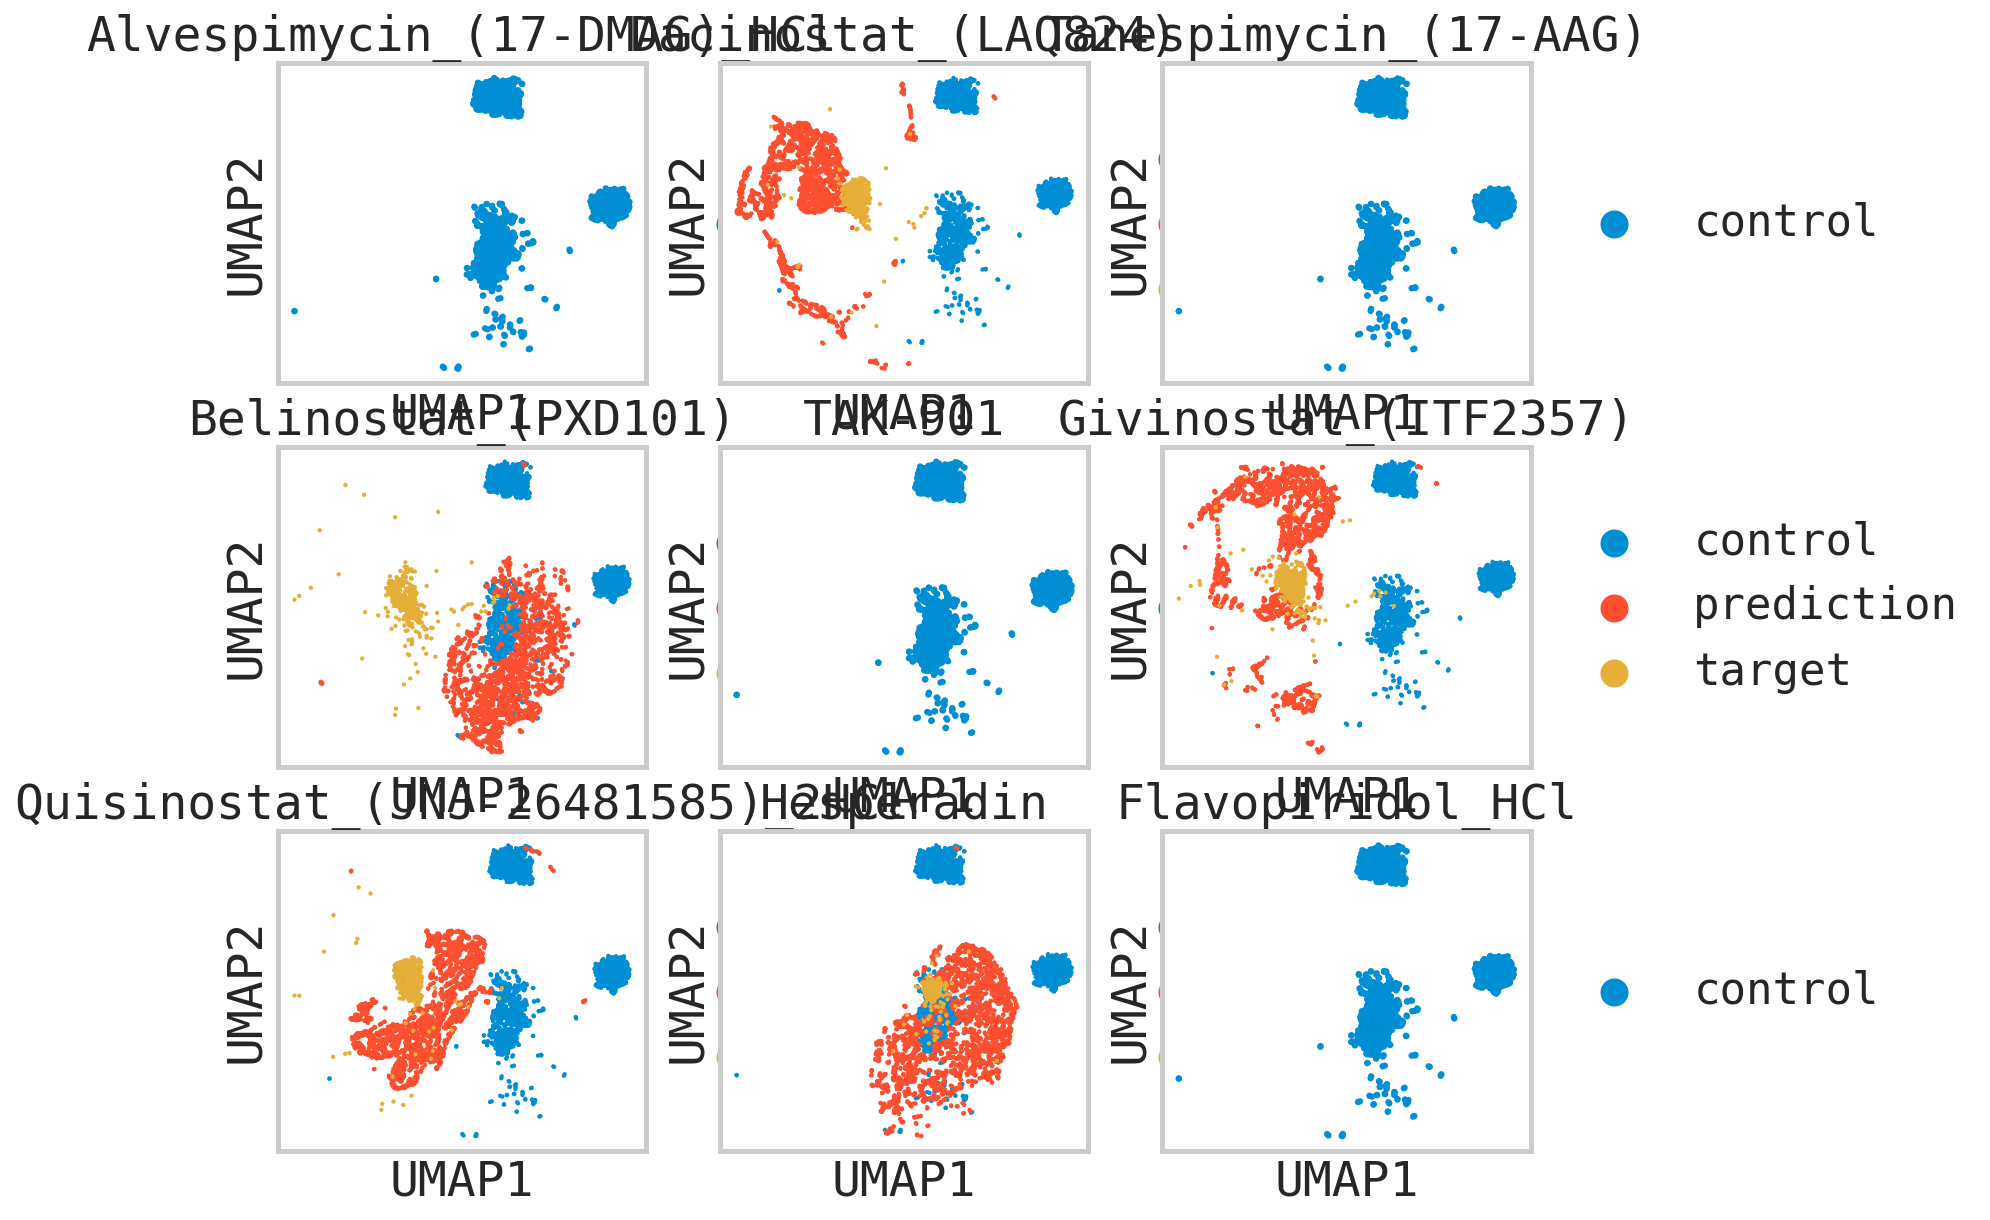

In [36]:
# cl = "MCF7"
# pert = "Tanespimycin"
# cond = (adata.obs["condition"] == "control") + ((adata.obs["cell_line"] == cl) * (adata.obs["perturbation"] == pert))
fig, ax = plt.subplots(3, 3, figsize=(10,10))
for i, pert in enumerate(ood_drugs):
    axis = ax[i//3, i%3]
    cond = (adata.obs["condition"] == "control") + (adata.obs["perturbation"] == pert)
    sc.pl.umap(adata[cond], color="condition", ax=axis, show=False)
    axis.set_title(f"{pert}")
plt.tight_layout()

## Non-pretrained model

In [38]:
config = load_config(seml_collection, model_hash_scratch)

config['dataset']['n_vars'] = dataset.n_vars
config["model"]["embedding"]["directory"] = ROOT / config["model"]["embedding"]["directory"]

model_scratch, embedding_scratch = load_model(config, canon_smiles_unique_sorted)

  0%|          | 0/12 [00:00<?, ?it/s]

In [39]:
drug_r2_scratch_degs, _ = compute_pred(model_scratch,
                                  datasets['ood'],
                                  genes_control=datasets['test_control'].genes, 
                                  dosages=dosages,
                                  cell_lines=cell_lines,
                                  use_DEGs=True,
                                  verbose=False,
                                 ) # non-pretrained

drug_r2_scratch_all, _ = compute_pred(model_scratch,
                                  datasets['ood'],
                                  genes_control=datasets['test_control'].genes, 
                                  dosages=dosages,
                                  cell_lines=cell_lines,
                                  use_DEGs=False,
                                  verbose=False,
                                 ) # non-pretrained

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

['A549', 'K562', 'MCF7']


0it [00:00, ?it/s]

# Combine results and create dataframe

In [40]:
def create_df(drug_r2_baseline, drug_r2_pretrained, drug_r2_scratch):
    df_baseline = pd.DataFrame.from_dict(drug_r2_baseline, orient='index', columns=['r2_de'])
    df_baseline['type'] = 'baseline'
    df_pretrained = pd.DataFrame.from_dict(drug_r2_pretrained, orient='index', columns=['r2_de'])
    df_pretrained['type'] = 'pretrained'
    df_scratch = pd.DataFrame.from_dict(drug_r2_scratch, orient='index', columns=['r2_de'])
    df_scratch['type'] = 'non-pretrained'

    df = pd.concat([df_pretrained, df_scratch, df_baseline])

    df['r2_de'] = df['r2_de'].apply(lambda x: max(x,0))
    df['cell_line'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[0]).values
    df['drug'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[1]).values
    df['dose'] = pd.Series(df.index.values).apply(lambda x: x.split('_')[2]).values
    df['dose'] = df['dose'].astype(float)

    df['combination'] = df.index.values
    assert (df[df.type=='pretrained'].combination == df[df.type=='non-pretrained'].combination).all()

    delta = (df[df.type=='pretrained'].r2_de - df[df.type=='non-pretrained'].r2_de).values 
    df['delta'] = list(delta) + list(-delta) + [0]*len(delta)

    df = df.reset_index()
    return df

In [41]:
df_degs = create_df(drug_r2_baseline_degs, drug_r2_pretrained_degs, drug_r2_scratch_degs)
df_all = create_df(drug_r2_baseline_all, drug_r2_pretrained_all, drug_r2_scratch_all)

# Plot Figure 2 with RDKit

In [42]:
SAVEFIG = False

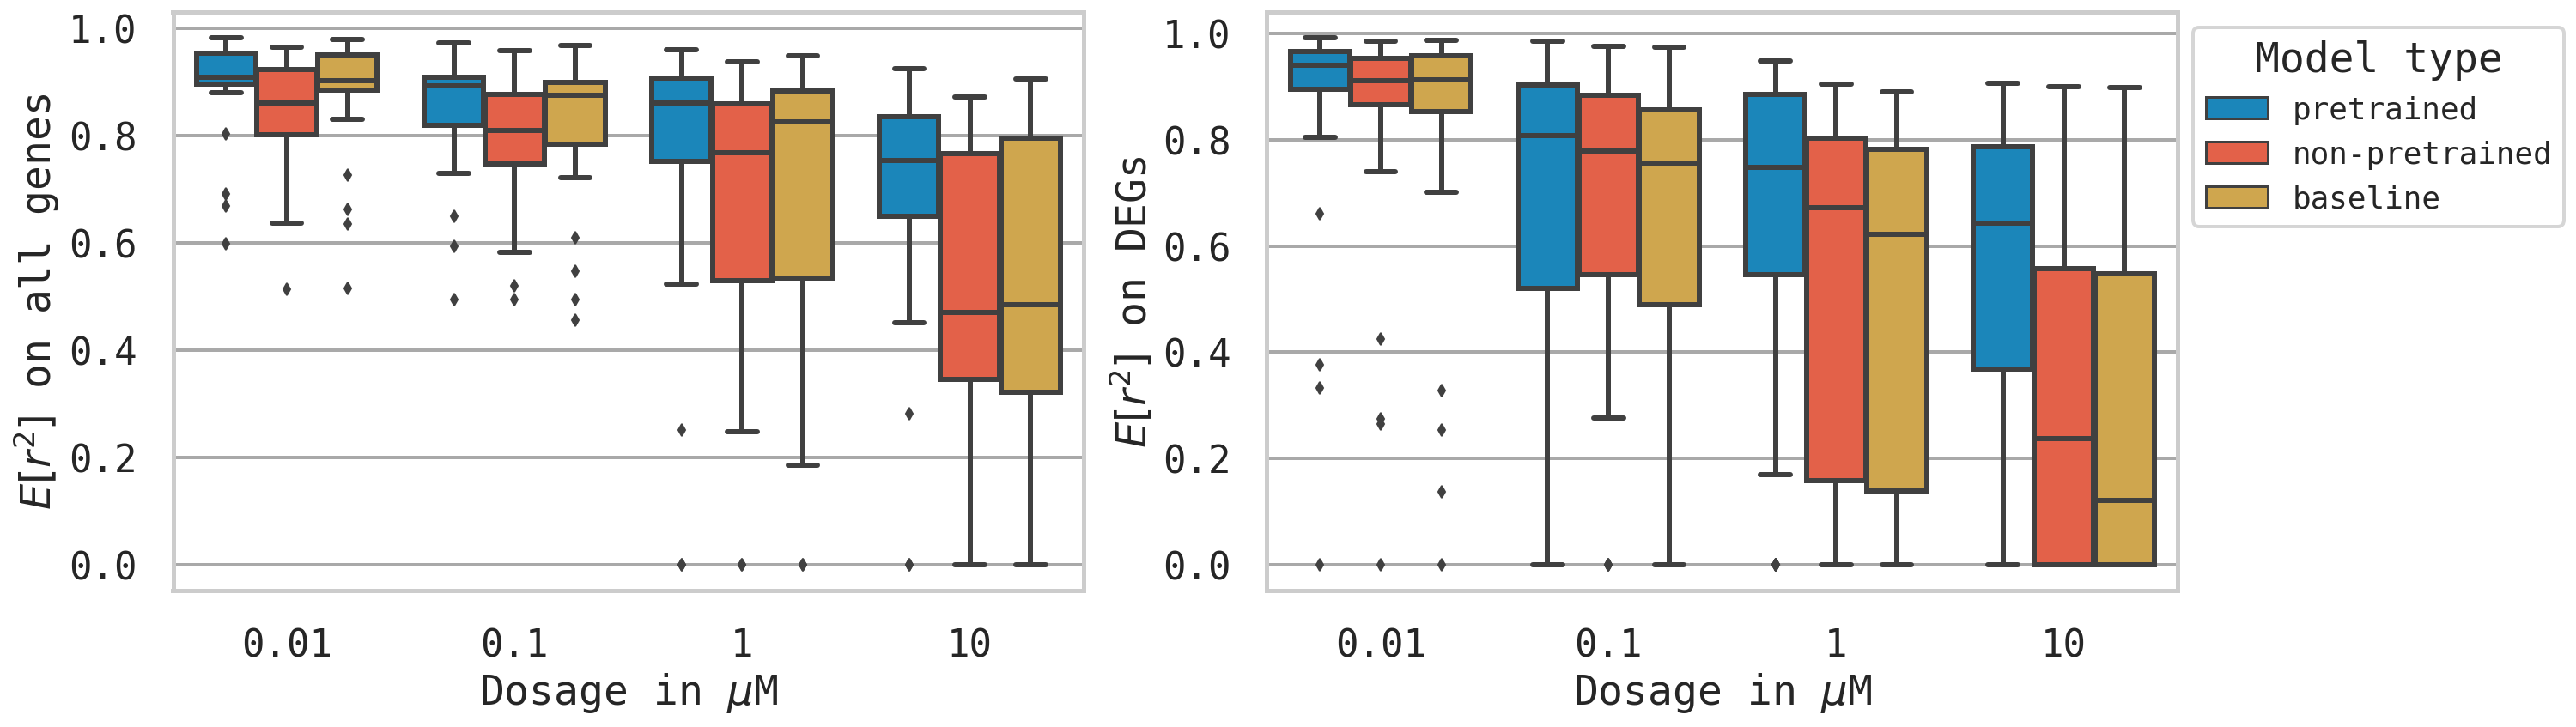

In [43]:
fig, ax = plt.subplots(1,2,figsize=(21, 6))

PROPS = {
    'boxprops':{'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'}, 
    'flierprops': {'markerfacecolor': 'lightgrey', "markeredgecolor": "lightgrey"}
}

if BLACK: 
    sns.boxplot(data=df_all, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[0], palette='tab10', **PROPS) # [(df.r2_de > 0) & (df.delta != 0)]
    sns.boxplot(data=df_degs, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[1], palette='tab10', **PROPS) # [(df.r2_de > 0) & (df.delta != 0)]
else:
    sns.boxplot(data=df_all, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[0])
    sns.boxplot(data=df_degs, x='dose', y='r2_de', hue='type', whis=1.5, ax=ax[1])

for j,axis in enumerate(ax):
    x_labels = axis.get_xticklabels()
    dose_labels = ['0.01', "0.1", '1', '10']
    [label.set_text(dose_labels[i]) for i,label in enumerate(x_labels)]
    axis.set_xticklabels(x_labels)
    axis.set_ylabel("$E[r^2]$ on DEGs") if j==1 else None
    axis.set_ylabel("$E[r^2]$ on all genes") if j==0 else None
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.grid('.', color='darkgrey', axis='y')

ax[0].legend().remove()
ax[1].legend(title='Model type', fontsize=18, title_fontsize=24, loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'RDKit_shared_gene_set_black.pdf', format='pdf') # BLACK:
    else:
        plt.savefig(FIGURE_DIR/'RDKit_shared_gene_set.pdf', format='pdf') # WHITE


________

# Additional: Supplement Figure 10/11 and Figure 5

In [ ]:
ood_drugs

## Supplement Figure 11 for RDKit
**Parameters**
* DEGs
* Shared genes

In [16]:
df = df_degs.copy()
df.dose = df.dose*10

rows, cols = 3,3
fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 4.5*rows))


for i, drug in enumerate(ood_drugs):
    axis = ax[i//cols, i%cols]
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=axis, palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    axis.set_title(drug)
#     ax[i].set()
    axis.set_ylim([0,1])
    axis.legend().remove()
    axis.set_ylabel("$E[r^2]$ on DEGs") 
    axis.set_ylabel("$E[r^2]$ on DEGs") 
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.set_xscale("log")

ax[0,2].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left", bbox_to_anchor=(1, 0.2))

plt.tight_layout()


if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_degs_black.png', format='png')
    else:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_degs.png', format='png')


NameError: name 'df_degs' is not defined

## Figure 5 for RDKit (DEGs)

In [ ]:
df = df_degs.copy()
df.dose = df.dose*10

STACKED = True

if STACKED:
    # Portrait
    fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
else:
    # Landscape
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)


for i, drug in enumerate(["Dacinostat", "Hesperadin"]):
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=ax[i], palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    ax[i].set_title(drug)
#     ax[i].set()
    ax[i].set_ylim([0,1])
    ax[i].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left") #, bbox_to_anchor=(1, 1)
    ax[i].grid('.', color='darkgrey')

ax[0].set_ylabel("$E[r^2]$ on DEGs") 
ax[1].set_ylabel("$E[r^2]$ on DEGs") 
ax[1].set_xlabel("Dosage in $\mu$M") 
ax[0].set_xlabel("Dosage in $\mu$M") 
ax[0].legend().remove()
ax[0].set_xscale("log")
ax[1].set_xscale("log")
plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_degs_black.png', format='png') # BLACK
    else:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_degs.png', format='png')

## Supplement Figure 10 for RDKit

**Parameters**
* All genes
* Shared genes

In [ ]:
df = df_all.copy()
df.dose = df.dose*10

rows, cols = 3,3
fig, ax = plt.subplots(rows, cols, figsize=(8*cols, 4.5*rows))


for i, drug in enumerate(ood_drugs):
    axis = ax[i//cols, i%cols]
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=axis, palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    axis.set_title(drug)
#     ax[i].set()
    axis.set_ylim([0,1])
    axis.legend().remove()
    axis.set_ylabel("$E[r^2]$ on all genes") 
    axis.set_ylabel("$E[r^2]$ on all genes") 
    axis.set_xlabel("Dosage in $\mu$M") 
    axis.set_xscale("log")

ax[0,2].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left", bbox_to_anchor=(1, 0.2))

plt.tight_layout()


if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_all_genes_black.png', format='png')
    else:
        plt.savefig(FIGURE_DIR/'all_drug_examples_rdkit_shared_all_genes.png', format='png')


## Figure 5 for RDKit (All genes)

In [ ]:
df = df_all.copy()
df.dose = df.dose*10


STACKED = False

if STACKED:
    # Portrait
    fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
else:
    # Landscape
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)


for i, drug in enumerate(["Dacinostat", "Hesperadin"]):
    sns.lineplot(x="dose", y="r2_de", data=df[(df.drug==drug)], hue="type", ax=ax[i], palette='tab10' if BLACK else None) # & (df.type!="baseline") & (df.cell_line ==cell_line)
    ax[i].set_title(drug)
#     ax[i].set()
    ax[i].set_ylim([0,1])
    ax[i].legend(title='Model type', fontsize=18, title_fontsize=24, loc="lower left") #, bbox_to_anchor=(1, 1)
    ax[i].grid('.', color='darkgrey')

ax[0].set_ylabel("$E[r^2]$ on all genes") 
ax[1].set_ylabel("$E[r^2]$ on all genes") 
ax[1].set_xlabel("Dosage in $\mu$M") 
ax[0].set_xlabel("Dosage in $\mu$M") 
ax[0].legend().remove()
ax[0].set_xscale("log")
ax[1].set_xscale("log")
plt.tight_layout()

if SAVEFIG:
    if BLACK:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_all_genes_black.png', format='png') # BLACK
    else:
        plt.savefig(FIGURE_DIR/'drug_examples_rdkit_shared_all_genes.png', format='png')

___